In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
# leggo il dataset ed il target

dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned-\dataset-.csv', header = 0)
features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1
    
print(pairs_number_features)

target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned-\target.csv', header = 0)

[(0, 'balance'), (1, 'lifetime'), (2, 'tx_in'), (3, 'investment_to_contract/tx_in'), (4, 'payment_from_contract/tx_out'), (5, '#addresses_paying_contract'), (6, '#addresses_paid_by_contract'), (7, 'mean_v1'), (8, 'sdev_v1'), (9, 'sdev_v2'), (10, 'paid_rate'), (11, 'paid_one'), (12, 'percentage_some_tx_in'), (13, 'sdev_tx_in'), (14, 'percentage_some_tx_out'), (15, 'known_rate'), (16, 'owner_gets_eth_Wo_investing')]


In [3]:
X = dataset.values[:, 1:] # rimuovo la prima colonna che contiene gli indirizzi
y = target.values

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

In [4]:
# vado a stampare il numero di non ponzi e ponzi presenti nel train set e nel test_set

flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))

Number of smart contract in train set:: 3107
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 777
Number of smart Ponzi in test set:: 135


In [5]:
fbeta = make_scorer(fbeta_score, beta = 1.5)

In [6]:
# in questo dizionario inserisco i parametri con cui testare il DT

param_dist_DT = {
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [8, 9, 10, 11, 12, None],
            'min_samples_split' : [18,20,22,24], # il valore tipico sta fra 1 e 40
            'class_weight': [{0:1, 1:4.6}, {0:1, 1:4.7}]
}

In [7]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = param_dist_DT, scoring = fbeta, cv = 3, n_jobs = 8)
grid_dt.fit(X_train, y_train) # alleno su train
y_pred_train = grid_dt.predict(X_train) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_dt.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_dt.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'class_weight': {0: 1, 1: 4.6}, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 20}
best score::  0.6006317974360792
recall score on TR::  0.8680297397769516
precision score on TR::  0.5566150178784267


In [10]:
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_dt.score(X_train, y_train))
print('accuracy score on TS:: ', clf_dt.score(X_test, y_test))

accuracy score on TR::  0.8784636488340192
accuracy score on TS::  0.8344298245614035


In [15]:
param_dist_RF = {
            'n_estimators':[200, 210, 220, 230],
            'min_samples_split' : [30, 35],
            'max_depth' : [6, 7, 8],
            'criterion':['entropy', 'gini'],
            'class_weight' : [{0:1, 1:5.5}],
            'bootstrap': [True, False]
}

In [16]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_dist_RF, scoring = fbeta, cv = 3, n_jobs = 8)
grid_rf.fit(X_train, y_train.ravel())
y_pred_train = grid_rf.predict(X_train)
print('best hyperparameters:: ', grid_rf.best_params_)
print('best score:: ', grid_rf.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'bootstrap': False, 'class_weight': {0: 1, 1: 5.5}, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 35, 'n_estimators': 210}
best score::  0.6188068703060162
recall score on TR::  0.8884758364312267
precision score on TR::  0.5026288117770767


In [19]:
clf_rf = RandomForestClassifier(**grid_rf.best_params_)
clf_rf.fit(X_train, y_train.ravel())
print('accuracy score on TR:: ', clf_rf.score(X_train, y_train))
print('accuracy score on TS:: ', clf_rf.score(X_test, y_test))

accuracy score on TR::  0.8493827160493828
accuracy score on TS::  0.8037280701754386


In [39]:
grid_param_XGB = {
                'learning_rate' : [0.05],
                'n_estimators' : [100, 120, 140, 160],
                'max_depth': [5, 6],
                'colsample_bytree' : [0.8],
                'subsample' : [0.8],
                'scale_pos_weight' : [5, 5.5],
                'gamma' : [0, 0.1, 0.2],
                'reg_lambda':[7, 15]
}

In [40]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'aucpr'), 
                        param_grid = grid_param_XGB, scoring = fbeta, cv = 3, n_jobs = 8)
grid_xgb.fit(X_train, y_train)
y_pred_train = grid_xgb.predict(X_train)
print('best hyperparameters:: ', grid_xgb.best_params_)
print('best score:: ', grid_xgb.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 140, 'reg_lambda': 15, 'scale_pos_weight': 5.5, 'subsample': 0.8}
best score::  0.6541988543948083
recall score on TR::  0.8773234200743495
precision score on TR::  0.6801152737752162


In [41]:
clf_xgb = xgb.XGBClassifier(learning_rate = 0.05, max_depth = 6, n_estimators = 140, scale_pos_weight = 5.5, gamma = 0,
                            reg_lambda = 15, colsample_bytree = 0.8, subsample = 0.8, use_label_encoder = False, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_xgb.score(X_train, y_train))
print('accuracy score on TS:: ', clf_xgb.score(X_test, y_test))

accuracy score on TR::  0.9209876543209876
accuracy score on TS::  0.8596491228070176


In [43]:
model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': { 
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [8, 9, 10, 11, 12, None],
            'min_samples_split' : [18,20,22,24], # il valore tipico sta fra 1 e 40
            'class_weight': [{0:1, 1:4.6}, {0:1, 1:4.7}]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[200, 210, 220, 230],
            'min_samples_split' : [30, 35],
            'max_depth' : [6, 7, 8],
            'criterion':['entropy', 'gini'],
            'class_weight' : [{0:1, 1:5.5}],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(learning_rate = 0.05, # funziona bene per valori fra 0.01 e 0.25
                                   eval_metric = 'aucpr', 
                                   use_label_encoder = False),
        'params': {
                'n_estimators' : [100, 120, 140, 160],
                'max_depth': [5, 6],
                'colsample_bytree' : [0.8],
                'subsample' : [0.8],
                'scale_pos_weight' : [5, 5.5],
                'gamma' : [0, 0.1, 0.2],
                'reg_lambda':[7, 15]
        }
    }
}

In [44]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring = fbeta, cv=3, return_train_score=False, n_jobs=8)
    clf.fit(X_train, y_train.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.601104,"{'class_weight': {0: 1, 1: 4.7}, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 22}"
1,random_forest,0.620749,"{'bootstrap': False, 'class_weight': {0: 1, 1: 5.5}, 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 30, 'n_estimators': 200}"
2,xgboost,0.654199,"{'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 6, 'n_estimators': 140, 'reg_lambda': 15, 'scale_pos_weight': 5.5, 'subsample': 0.8}"


In [45]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train, y_train.ravel()) # rialleno

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='aucpr', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=15,
              scale_pos_weight=5.5, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

                    (Number, Feature)  Importance
0                      (11, paid_one)    0.228802
1                    (15, known_rate)    0.154757
2                          (2, tx_in)    0.076843
3                    (13, sdev_tx_in)    0.053847
4   (3, investment_to_contract/tx_in)    0.048475
5   (4, payment_from_contract/tx_out)    0.045505
6         (12, percentage_some_tx_in)    0.042296
7                        (9, sdev_v2)    0.041612
8                        (7, mean_v1)    0.040486
9                        (0, balance)    0.038395
10                      (1, lifetime)    0.037781
11                    (10, paid_rate)    0.037316
12   (6, #addresses_paid_by_contract)    0.035595
13                       (8, sdev_v1)    0.031562
14  (16, owner_gets_eth_Wo_investing)    0.031243
15       (14, percentage_some_tx_out)    0.031199
16    (5, #addresses_paying_contract)    0.024287


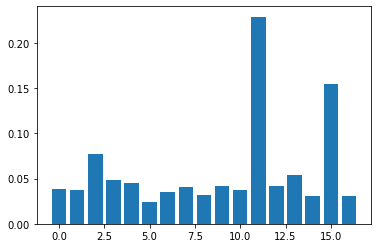

In [46]:
features_importances = clf.feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))
print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

precision score::  0.5207100591715976
recall score::  0.6518518518518519
accuracy score::  0.8596491228070176
fbeta score::  0.6205923836389281
F1 score:: 0.5789473684210527


<AxesSubplot:>

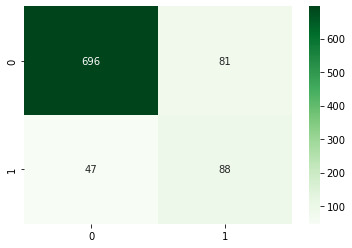

In [47]:
# faccio la predizione e stampo le statistiche sul modello migliore (quello che ha vinto nella GridSearch)

y_pred = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('fbeta score:: ', fbeta_score(y_test, y_pred, beta = 2))
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

precision score::  0.4192139737991266
recall score::  0.7111111111111111
accuracy score::  0.8114035087719298
F1 score:: 0.5274725274725274


<AxesSubplot:>

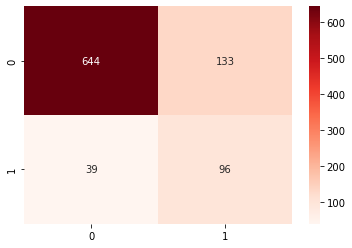

In [48]:
# risultati ottenuti con il secondo migliore

model = models_list[1] # prendo il modello medio
clf2 = model.get('best_estimator') # ottengo i valori con cui allenare
clf2.fit(X_train, y_train.ravel()) # rialleno
y_pred2 = clf2.predict(X_test)
#print(clf2.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred2)) #  TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred2))	     # 	TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred2))	 #  (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred2))
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')

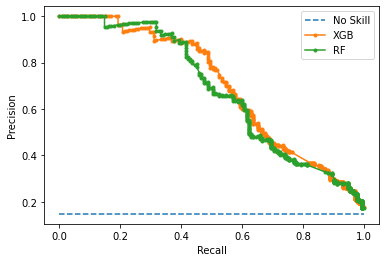

In [49]:
# predict probabilities
y_pred_proba_winner = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_pred_proba_w = y_pred_proba_winner[:, 1]
# calculate pr-curve
p, r, thrs = precision_recall_curve(y_test, y_pred_proba_w)


y_pred_proba_second = clf2.predict_proba(X_test)
y_pred_proba_s = y_pred_proba_second[:, 1]
p2, r2, thrs2 = precision_recall_curve(y_test, y_pred_proba_s)
# plot the roc curve for the model
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.plot(r, p, marker = '.', label = 'XGB')
plt.plot(r2, p2, marker = '.', label = 'RF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [50]:
# convert to f score
beta = 1.75 # se metto valori <= 1 allora e' come favorire F1 o precision, piu' alzo beta e piu' importanza ha la recall
fbetaw = ((1 + beta**2) * p * r) / (beta**2 * p + r)
# locate the index of the largest f score
ixw = np.argmax(fbetaw)
fbetas = ((1 + beta**2) * p2 * r2) / (beta**2 * p2 + r2)
ixs = np.argmax(fbetas)
print('Best Threshold of the winner model = %f, Fbeta-Score = %.3f' % (thrs[ixw], fbetaw[ixw]))
print('Best Threshold of the second model = %f, Fbeta-Score = %.3f' % (thrs2[ixs], fbetas[ixs]))

Best Threshold of the winner model = 0.346740, Fbeta-Score = 0.636
Best Threshold of the second model = 0.348776, Fbeta-Score = 0.625


<AxesSubplot:>

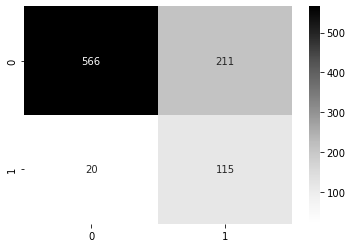

In [51]:
y_pred_thrs = np.where(clf.predict_proba(X_test)[:, 1] > thrs[ixw], 1, 0)
cm_thrs = confusion_matrix(y_test, y_pred_thrs)
sns.heatmap(cm_thrs, annot=True, cmap='Greys', fmt='d')

<AxesSubplot:>

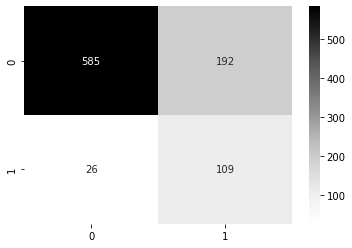

In [52]:
y_pred_thrs = np.where(clf2.predict_proba(X_test)[:, 1] > thrs2[ixs], 1, 0)
cm_thrs = confusion_matrix(y_test, y_pred_thrs)
sns.heatmap(cm_thrs, annot=True, cmap='Greys', fmt='d')